**Example 2.9:** Image rotation and intensity interpolation.

This includes figure 2.36

> This code is written with Julia v1.0.0

In [1]:
cd("/home/jc/Documents/Digital-Image-Processing-Gonzalez/DIP3E/Codes/Julia/Chapter-2/")
using Printf # format string in C style
using Images # core package for image
using CoordinateTransformations, Interpolations # for image rotation

summary(img_ori) = "540×420 Array{Gray{Float32},2} with eltype Gray{Float32}"


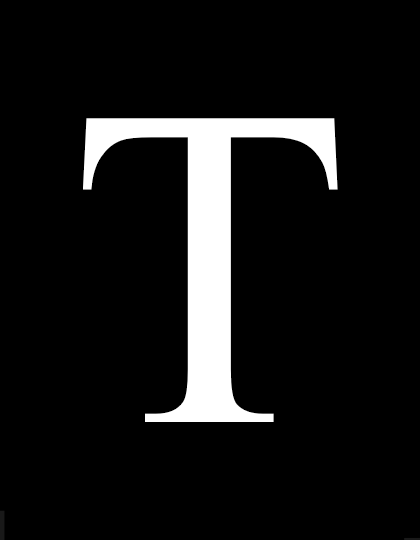

In [2]:
img_ori = load("Data/Fig0236(a)(letter_T).tif") .|> float32 # use Float32 to avoid unwanted overflow in N0f8
@show summary(img_ori)

img_ori

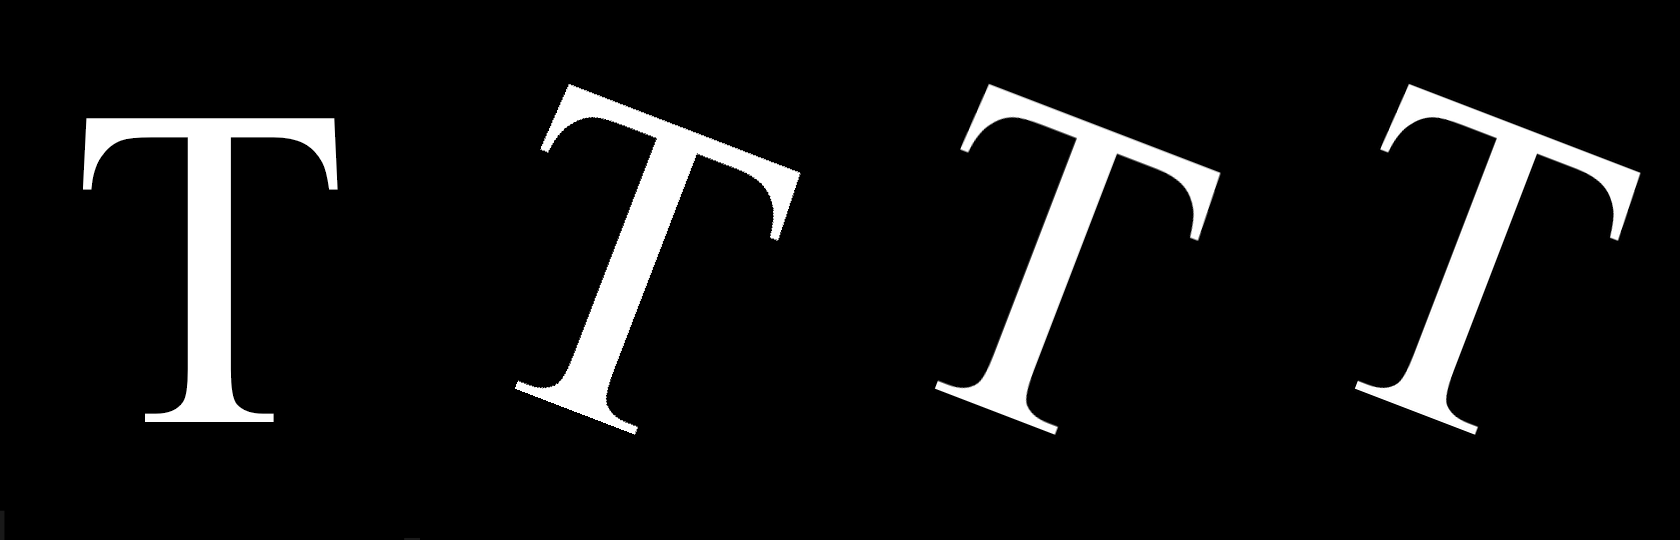

In [3]:
rot_deg = 21
tfm = recenter(RotMatrix((2pi)/(360/rot_deg)), center(img_ori))
imgs_rotate = [warp(img_ori, tfm, axes(img_ori), interp) 
    for interp in [Constant(), Linear(), Cubic(Line())]]

[img_ori hcat(imgs_rotate...)]

事实上，我写了一个`imrotate` wrapper来完成这一工作，见[JuliaImages/ImageTransformations.jl#58 (comment)](https://github.com/JuliaImages/ImageTransformations.jl/pull/58)

In [4]:
"""
    imrotate(img, angle; fill = NaN, method = "nearest", bbox = "loose") -> imgout

Rotate image `img` by `angle` degrees in a counterclockwise direction around its center point. To rotate the image clockwise, specify a negative value for angle.

# Arguments
- `img::AbstractArray`: image to be rotated
- `angle::Real`: amount of rotation in degrees. The rotation is in counterclockwise direction.
- `fill::Real`: filling value for pixel outside of original image. Defaults: `NaN` if the element type supports it, and `0` otherwise
- `method::String = "nearest"`: the interpolation method used in rotation. Options are "nearest" or "bilinear"
- `bbox::String = "loose"`: the bounding box defines the size of output image. If `bbox = "crop"`, then output image `imgout` are cropped to has the same size of input image `img`. If `bbox = "loose"`, then `imgout` is large enough to contain the entire rotated image; `imgout` is larger than `img`.

See also [`warp`](@ref).
"""
function imrotate(img::AbstractArray{T}, angle::Real; fill = NaN, method::String = "nearest", bbox::String = "loose")::AbstractArray{T} where T

    # FIXME: Bicubic method does not support N0f8 type.
    args = []
    push!(args,
        if method == "nearest"
            Constant()
        elseif method == "bilinear"
            Linear()
        else
            ArgumentError("method should be: nearest, bilinear")
        end)
    if !isnan(fill)
        push!(args, fill)
    end

    rotate_fun(img, tform, args...) =
    if bbox == "loose"
        warp(img, tform, args...)
    elseif bbox == "crop"
        warp(img, tform, axes(img), args...)
    else
        ArgumentError("bbox should be: loose, crop")
    end
    
    tfm = recenter(RotMatrix{2}(mod2pi(1*angle)), center(img))
    rotate_fun(img, tfm, args...)
end

imrotate (generic function with 1 method)

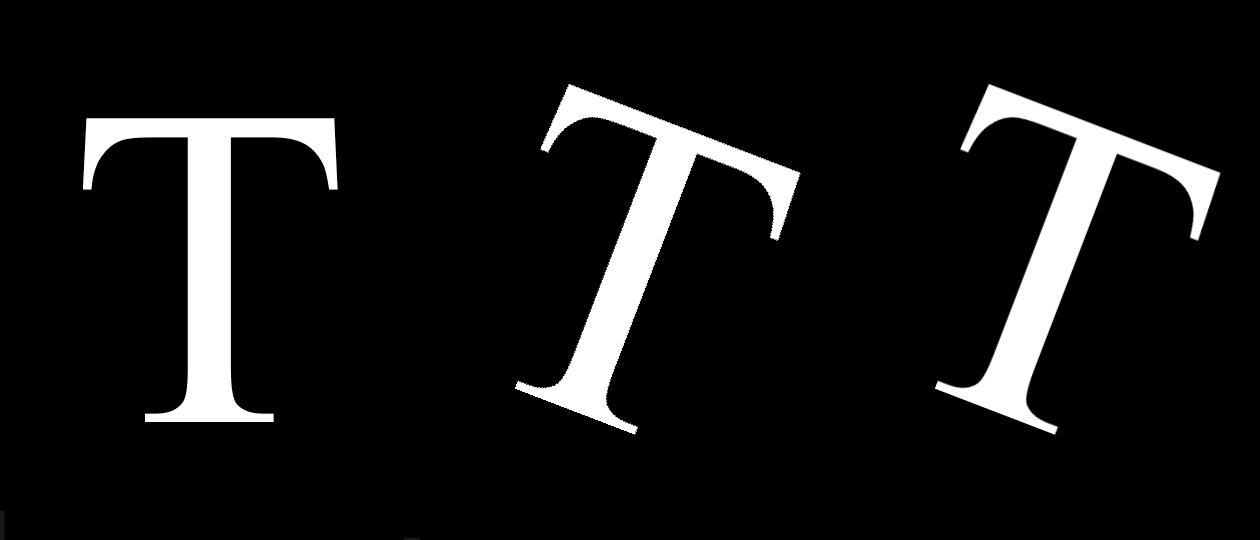

In [5]:
rot_deg = 21
imgs_rotate = [imrotate(img_ori,rot_deg*pi/180,method=method,bbox="crop")
    for method in ["nearest","bilinear"]]

[img_ori hcat(imgs_rotate...)]